**IMPORT PACKAGES**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Deep Learning libraries (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# For mounting Google Drive in Colab
from google.colab import drive

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

**MOUNT GOOGLE DRIVE AND LOAD DATA**

In [ ]:
drive.mount('/content/drive')

# Define the base path where the files are stored
base_path = '/content/drive/My Drive/IOT_Dataset'

# File paths for the three files:
train_file = os.path.join(base_path, 'train_ML_IOT.csv')
test_file  = os.path.join(base_path, 'test_ML_IOT.csv')
sample_submission_file = os.path.join(base_path, 'sample_submission_ML_IOT.csv')

Mounted at /content/drive


**LOAD DATA**

In [ ]:
train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)
sample_submission_df = pd.read_csv(sample_submission_file)

**EXPLORATORY DATA ANALYSIS (EDA)**

In [ ]:
print("TRAIN DATA SAMPLE:")
display(train_df.head())

print("\nTRAIN DATA INFO:")
train_df.info()

print("\nSUMMARY STATISTICS:")
display(train_df.describe())

print("\nMISSING VALUES IN TRAINING DATA:")
display(train_df.isnull().sum())

num_duplicates = train_df.duplicated().sum()
print(f"\nNumber of duplicate rows in train data: {num_duplicates}")
if num_duplicates > 0:
    train_df.drop_duplicates(inplace=True)
    print("Duplicate rows removed.")

TRAIN DATA SAMPLE:


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041



TRAIN DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB

SUMMARY STATISTICS:


,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10



MISSING VALUES IN TRAINING DATA:


,0
DateTime,0
Junction,0
Vehicles,0
ID,0



Number of duplicate rows in train data: 0


**KPI METRICS & SUMMARY VISUALIZATIONS**

Average Vehicles per Junction:


,Junction,Vehicles
0,1,45.052906
1,2,14.253221
2,3,13.694010
3,4,7.251611


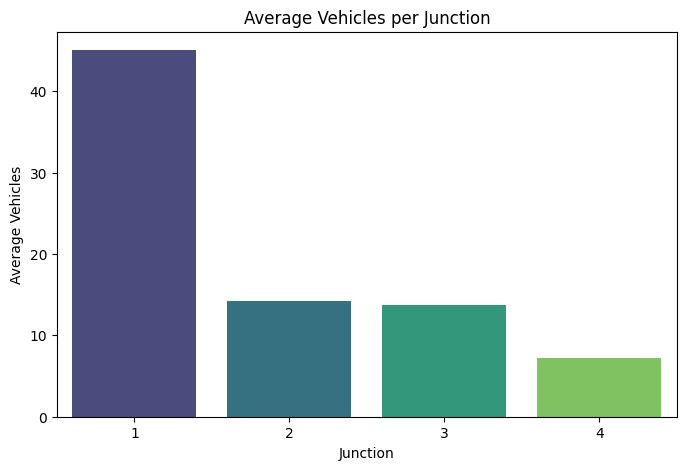

Daily Total Vehicles (first 5 rows):


,DateTime,Vehicles
0,2015-11-01,596
1,2015-11-02,909
2,2015-11-03,911
3,2015-11-04,818
4,2015-11-05,770


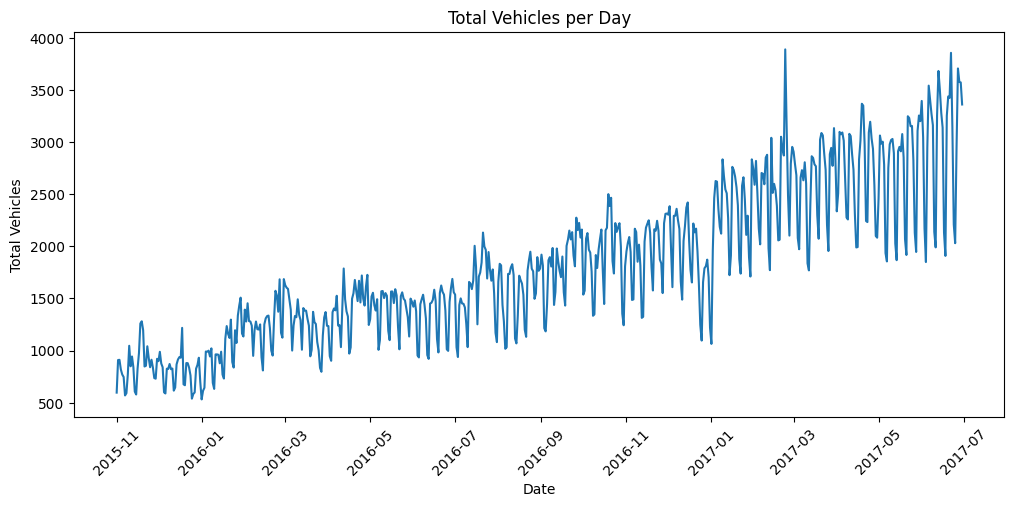

Peak Vehicle Count (Day):


,DateTime,Vehicles
480,2017-02-23,3892


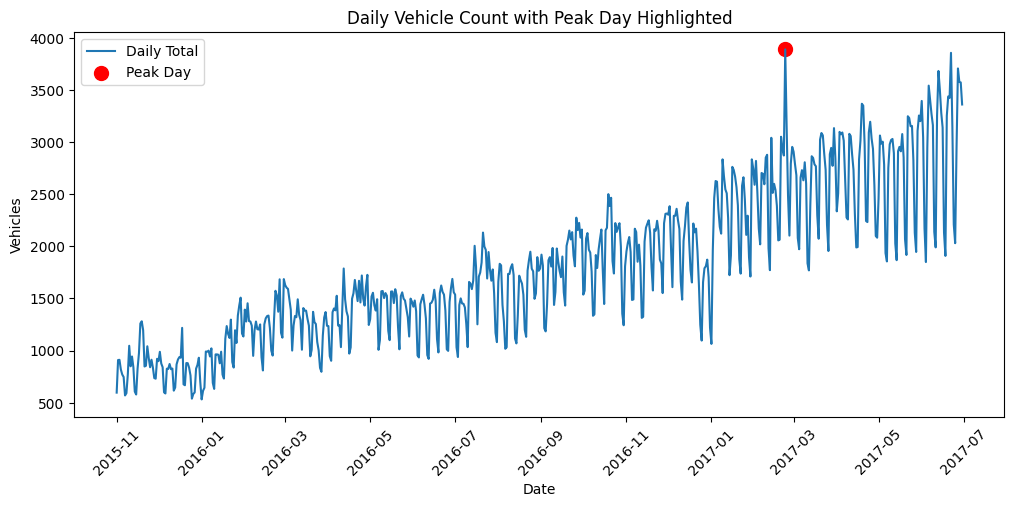

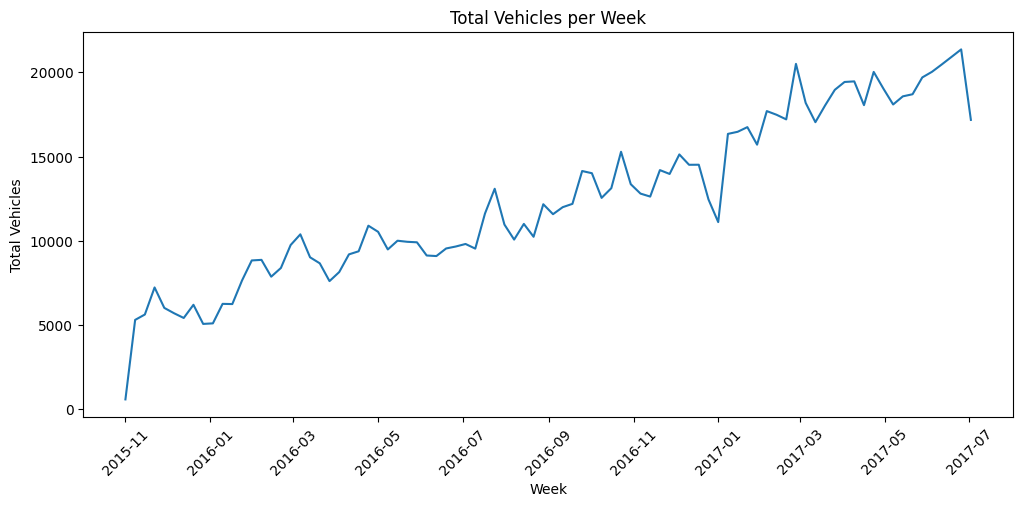

Peak Total Vehicles: 270844
Off-Peak Total Vehicles: 825875
Peak vs. Off-Peak Ratio: 0.327947934009384


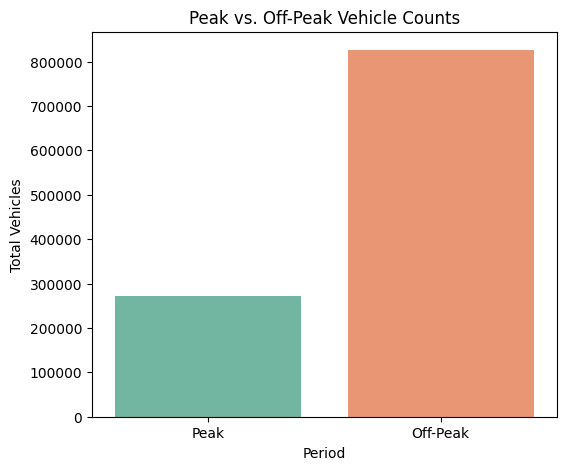

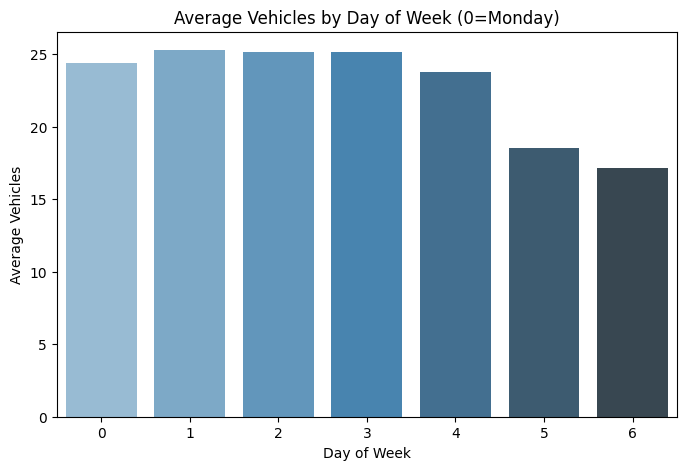

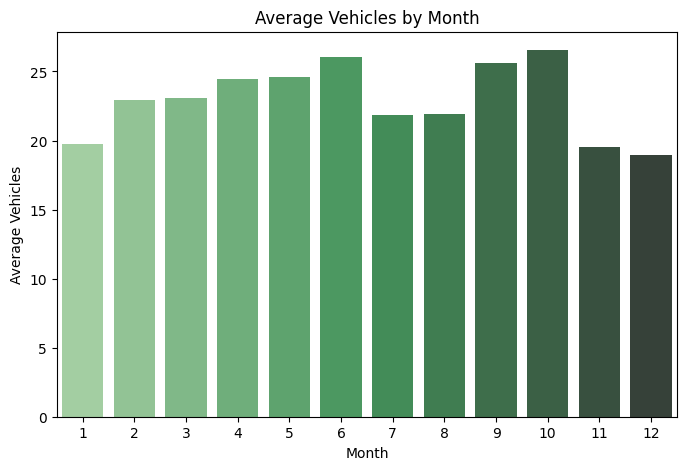

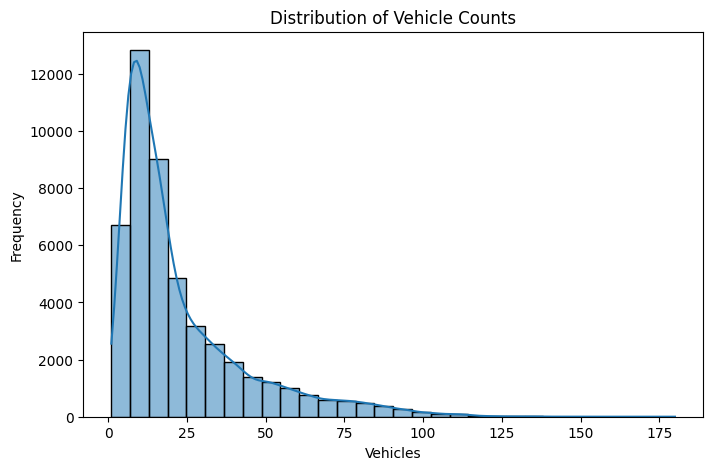

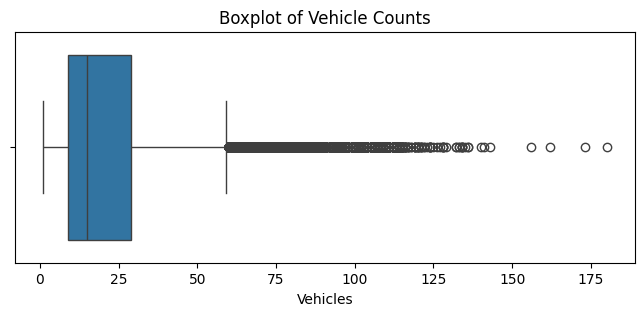

Standard Deviation of Vehicles: 20.750062520031733
Variance of Vehicles: 430.56509458522567


In [ ]:
# 1.1. Average Vehicles per Junction
avg_vehicles = raw_train_df.groupby('Junction')['Vehicles'].mean().reset_index()
print("Average Vehicles per Junction:")
display(avg_vehicles)
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_vehicles, x='Junction', y='Vehicles', palette='viridis')
plt.title('Average Vehicles per Junction')
plt.xlabel('Junction')
plt.ylabel('Average Vehicles')
plt.show()

# 1.2. Daily Total Vehicles
daily_total = raw_train_df.set_index('DateTime').resample('D')['Vehicles'].sum().reset_index()
print("Daily Total Vehicles (first 5 rows):")
display(daily_total.head())
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_total, x='DateTime', y='Vehicles')
plt.title('Total Vehicles per Day')
plt.xlabel('Date')
plt.ylabel('Total Vehicles')
plt.xticks(rotation=45)
plt.show()

# 1.3. Peak Vehicle Count (Identify the day with the maximum vehicles)
peak_day = daily_total[daily_total['Vehicles'] == daily_total['Vehicles'].max()]
print("Peak Vehicle Count (Day):")
display(peak_day)
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_total, x='DateTime', y='Vehicles', label='Daily Total')
plt.scatter(peak_day['DateTime'], peak_day['Vehicles'], color='red', s=100, label='Peak Day')
plt.title('Daily Vehicle Count with Peak Day Highlighted')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2.1. Weekly Trends: Total Vehicles per Week
weekly_total = raw_train_df.set_index('DateTime').resample('W')['Vehicles'].sum().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_total, x='DateTime', y='Vehicles')
plt.title('Total Vehicles per Week')
plt.xlabel('Week')
plt.ylabel('Total Vehicles')
plt.xticks(rotation=45)
plt.show()

# 2.2. Peak vs. Off-Peak Traffic Ratio
raw_train_df['hour'] = raw_train_df['DateTime'].dt.hour
raw_train_df['Peak'] = raw_train_df['hour'].apply(lambda h: 1 if (7 <= h <= 9 or 17 <= h <= 19) else 0)
peak_total = raw_train_df[raw_train_df['Peak'] == 1]['Vehicles'].sum()
offpeak_total = raw_train_df[raw_train_df['Peak'] == 0]['Vehicles'].sum()
print("Peak Total Vehicles:", peak_total)
print("Off-Peak Total Vehicles:", offpeak_total)
ratio = peak_total / offpeak_total if offpeak_total != 0 else np.nan
print("Peak vs. Off-Peak Ratio:", ratio)
plt.figure(figsize=(6, 5))
ratio_df = pd.DataFrame({'Period': ['Peak', 'Off-Peak'], 'Vehicles': [peak_total, offpeak_total]})
sns.barplot(data=ratio_df, x='Period', y='Vehicles', palette='Set2')
plt.title('Peak vs. Off-Peak Vehicle Counts')
plt.ylabel('Total Vehicles')
plt.show()

# 2.3. Day-of-Week Traffic Variation
raw_train_df['DayOfWeek'] = raw_train_df['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
dow_avg = raw_train_df.groupby('DayOfWeek')['Vehicles'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=dow_avg, x='DayOfWeek', y='Vehicles', palette='Blues_d')
plt.title('Average Vehicles by Day of Week (0=Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Vehicles')
plt.show()

# 2.4. Month-over-Month Traffic Variation
raw_train_df['Month'] = raw_train_df['DateTime'].dt.month
monthly_avg = raw_train_df.groupby('Month')['Vehicles'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=monthly_avg, x='Month', y='Vehicles', palette='Greens_d')
plt.title('Average Vehicles by Month')
plt.xlabel('Month')
plt.ylabel('Average Vehicles')
plt.show()


# 3.1. Traffic Volume Distribution (Histogram)
plt.figure(figsize=(8, 5))
sns.histplot(raw_train_df['Vehicles'], bins=30, kde=True)
plt.title('Distribution of Vehicle Counts')
plt.xlabel('Vehicles')
plt.ylabel('Frequency')
plt.show()

# 3.2. Traffic Volume Distribution (Box Plot)
plt.figure(figsize=(8, 3))
sns.boxplot(x=raw_train_df['Vehicles'])
plt.title('Boxplot of Vehicle Counts')
plt.xlabel('Vehicles')
plt.show()

# 3.3. Variability: Standard Deviation and Variance
std_vehicles = raw_train_df['Vehicles'].std()
var_vehicles = raw_train_df['Vehicles'].var()
print("Standard Deviation of Vehicles:", std_vehicles)
print("Variance of Vehicles:", var_vehicles)

**DATA CLEANING & FEATURE ENGINEERING**

In [ ]:
# Convert the 'DateTime' column to datetime format for both train and test data
if 'DateTime' in train_df.columns:
    train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
    test_df['DateTime'] = pd.to_datetime(test_df['DateTime'])

    # Extract useful date/time features
    for df in [train_df, test_df]:
        df['year'] = df['DateTime'].dt.year
        df['month'] = df['DateTime'].dt.month
        df['day'] = df['DateTime'].dt.day
        df['hour'] = df['DateTime'].dt.hour
        df['dayofweek'] = df['DateTime'].dt.dayofweek

# Create a binary feature 'peak_hour': 1 if during typical rush hours (7-9 AM or 5-7 PM), else 0
def label_peak_hour(hour):
    return 1 if (7 <= hour <= 9 or 17 <= hour <= 19) else 0

if 'hour' in train_df.columns:
    train_df['peak_hour'] = train_df['hour'].apply(label_peak_hour)
    test_df['peak_hour'] = test_df['hour'].apply(label_peak_hour)

# Drop the raw DateTime column after extracting features
drop_cols = ['DateTime']
train_df.drop(columns=[col for col in drop_cols if col in train_df.columns], inplace=True)
test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], inplace=True)

**PREPARE DATA FOR REGRESSION**

In [ ]:
X = train_df.drop(columns=['Vehicles', 'ID'])
y = train_df['Vehicles']

# For the test set, store the ID (to use in submission) and remove it from predictors.
test_ids = test_df['ID'].copy()
X_test = test_df.drop(columns=['ID'])

** DATA ENCODING & SCALING**

In [ ]:
# Identify categorical features; here, 'Junction' is a candidate.
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical features for both train and test data
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure that the test set has the same feature columns as the training set
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

**SPLIT DATA INTO TRAINING AND VALIDATION SETS (REGRESSION)**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Training samples: 38496, Validation samples: 9624


**BASELINE REGRESSION MODEL: LINEAR REGRESSION**

In [ ]:
print("\n--- Baseline Model: Linear Regression ---")
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on the validation set and calculate RMSE
y_val_pred_lin = lin_reg.predict(X_val)
rmse_lin = np.sqrt(mean_squared_error(y_val, y_val_pred_lin))
print(f"Baseline Linear Regression RMSE: {rmse_lin:.4f}")


--- Baseline Model: Linear Regression ---
Baseline Linear Regression RMSE: 12.7495


**IMPROVED DEEP LEARNING REGRESSION MODEL**

In [ ]:
print("\n--- Improved Model: Deep Learning Regression ---")
input_dim = X_train.shape[1]

# Build a feedforward neural network for regression
dl_model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Linear activation for regression output
])
dl_model.compile(optimizer='adam', loss='mean_squared_error')
dl_model.summary()

# Train the deep learning model
history = dl_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=50, batch_size=32, verbose=1)

# Evaluate the deep learning model on the validation set
y_val_pred_dl = dl_model.predict(X_val).flatten()
rmse_dl = np.sqrt(mean_squared_error(y_val, y_val_pred_dl))
print(f"Deep Learning Model RMSE: {rmse_dl:.4f}")


--- Improved Model: Deep Learning Regression ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 16017.1943 - val_loss: 457.7914
Epoch 2/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 539.6782 - val_loss: 412.7834
Epoch 3/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 499.0897 - val_loss: 414.3736
Epoch 4/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 472.7560 - val_loss: 425.7848
Epoch 5/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 467.8143 - val_loss: 407.0204
Epoch 6/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 464.4590 - val_loss: 407.4014
Epoch 7/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 444.3541 - val_loss: 314.8279
Epoch 8/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 356.4174 - val_loss: 203.9008
Epoch 9/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 269.3614 - val_loss: 176.2322
Epoch 10/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 242.1375 - val_loss: 173.3762
Epoch 11/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 235.1713 - val

**PREDICTION ON TEST DATA & EXPORTING SUBMISSION FILE**

In [ ]:
# Use the deep learning model to predict 'Vehicles' for the test set
test_pred = dl_model.predict(X_test).flatten()

# Create a submission DataFrame using the sample submission format
submission_df = sample_submission_df.copy()
submission_df['Vehicles'] = test_pred

# Optionally, ensure that the IDs match the test file
# (Here we assume that the sample submission file already has the correct IDs.)
output_submission_file = os.path.join(base_path, 'test_with_predictions.csv')
submission_df.to_csv(output_submission_file, index=False)
print(f"\nTest predictions saved to: {output_submission_file}")

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Test predictions saved to: /content/drive/My Drive/IOT_Dataset/test_with_predictions.csv


**TIME SERIES PREDICTION USING LSTM**

Available junctions: [1 2 3 4]
Number of days in the time series: 608


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.3152 - val_loss: 0.0887
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0198 - val_loss: 0.0123
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0102 - val_loss: 0.0122
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0103 - val_loss: 0.0112
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0106 - val_loss: 0.0126
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

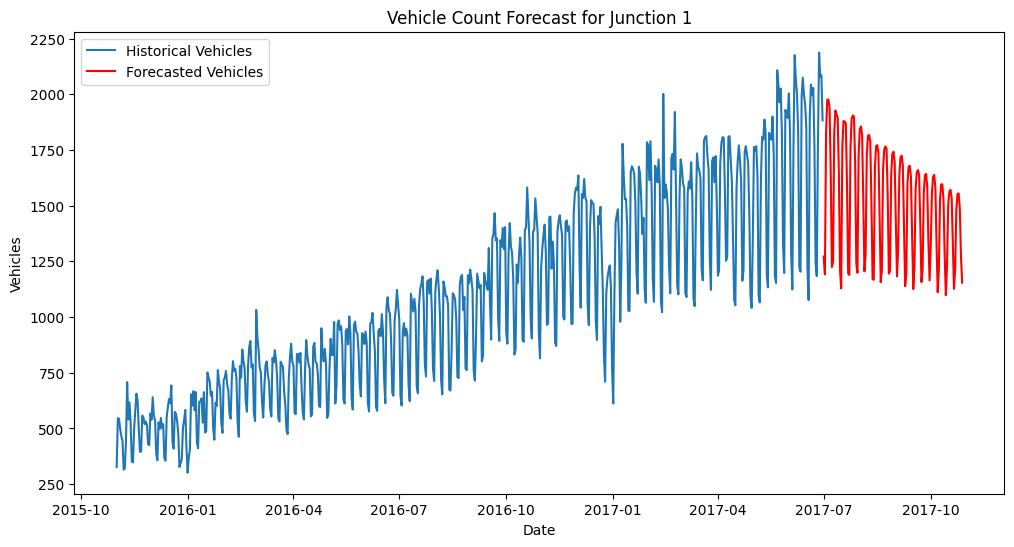

In [ ]:
raw_train_df = pd.read_csv(train_file)

# Verify the 'DateTime' column
if 'DateTime' not in raw_train_df.columns:
    raise ValueError("The 'DateTime' column was not found in the raw training data. Please verify your CSV file.")

# Convert 'DateTime' to datetime and sort
raw_train_df['DateTime'] = pd.to_datetime(raw_train_df['DateTime'])
raw_train_df.sort_values('DateTime', inplace=True)

# Print available junctions
if 'Junction' in raw_train_df.columns:
    available_junctions = raw_train_df['Junction'].unique()
    print("Available junctions:", available_junctions)
else:
    print("No 'Junction' column found; using the full dataset for time series forecasting.")

# Filter for a specific junction (optional)
desired_junction = 1  # Change as needed (1, 2, 3, or 4)
if 'Junction' in raw_train_df.columns and desired_junction in raw_train_df['Junction'].unique():
    ts_df = raw_train_df[raw_train_df['Junction'] == desired_junction].copy()
    junction_label = f"Junction {desired_junction}"
else:
    print(f"Junction '{desired_junction}' not found. Using the entire dataset.")
    ts_df = raw_train_df.copy()
    junction_label = "All Junctions"

# Set 'DateTime' as the index
ts_df.set_index('DateTime', inplace=True)

# Resample to daily frequency (sum Vehicles)
daily_vehicles = ts_df['Vehicles'].resample('D').sum()
print("Number of days in the time series:", len(daily_vehicles))
if daily_vehicles.empty:
    raise ValueError("No data found after resampling. Check your filtering criteria or CSV contents.")

# Log transform & scale the data
daily_vehicles_logged = np.log1p(daily_vehicles)  # log(1 + x)

ts_scaler = MinMaxScaler()
vehicles_scaled = ts_scaler.fit_transform(daily_vehicles_logged.values.reshape(-1, 1))

# Create sequences for LSTM input
def create_sequences(data, seq_length):
    """
    Create input-output sequences for LSTM.
    data: scaled time series data
    seq_length: number of time steps per sequence
    """
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i : i + seq_length])
        y_seq.append(data[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30  # Use the past 30 days to predict the next day
X_seq, y_seq = create_sequences(vehicles_scaled, seq_length)

# Split into training & validation
split_idx = int(len(X_seq) * 0.8)
X_train_ts, X_val_ts = X_seq[:split_idx], X_seq[split_idx:]
y_train_ts, y_val_ts = y_seq[:split_idx], y_seq[split_idx:]

# Build & compile the LSTM model
ts_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
ts_model.compile(optimizer='adam', loss='mean_squared_error')
ts_model.summary()

# Train the LSTM model
history_ts = ts_model.fit(
    X_train_ts, y_train_ts,
    epochs=50, batch_size=16,
    validation_data=(X_val_ts, y_val_ts),
    verbose=1
)

# Forecast future vehicle counts
forecast_steps = 120
forecast = []

# Start with the last sequence from vehicles_scaled
last_sequence = vehicles_scaled[-seq_length:]
current_seq = last_sequence.copy()

for _ in range(forecast_steps):
    current_seq_reshaped = current_seq.reshape((1, seq_length, 1))
    pred = ts_model.predict(current_seq_reshaped, verbose=0)
    forecast.append(pred[0, 0])
    # Slide the window forward
    current_seq = np.append(current_seq[1:], pred, axis=0)

# Inverse transform the forecast
# Inverse MinMaxScaler (back to logged scale)
forecast_inversed_logged = ts_scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
# Exponentiate minus 1 to revert log(1 + x) => x
forecast_final = np.expm1(forecast_inversed_logged)

# Create a DataFrame for the forecast
last_date = daily_vehicles.index[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)

forecast_df = pd.DataFrame({
    'DateTime': forecast_dates,
    'Predicted_Vehicles': forecast_final.flatten()
})

# Plot historical vs. forecasted vehicles
plt.figure(figsize=(12, 6))
plt.plot(daily_vehicles.index, daily_vehicles.values, label='Historical Vehicles')
plt.plot(forecast_df['DateTime'], forecast_df['Predicted_Vehicles'],
         label='Forecasted Vehicles', color='red')
plt.xlabel("Date")
plt.ylabel("Vehicles")
plt.title(f"Vehicle Count Forecast for {junction_label}")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Define file paths
train_file = '/content/drive/My Drive/IOT_Dataset/train_ML_IOT.csv'
forecast_output_path = '/content/drive/My Drive/IOT_Dataset/combined_actual_forecast.csv'
final_csv_path = '/content/drive/My Drive/IOT_Dataset/all_kpi_data.csv'

#Load and Prepare the Raw Data
raw_train_df = pd.read_csv(train_file)
if 'DateTime' not in raw_train_df.columns:
    raise ValueError("The 'DateTime' column was not found in the CSV file.")

raw_train_df['DateTime'] = pd.to_datetime(raw_train_df['DateTime'])
raw_train_df.sort_values('DateTime', inplace=True)

# KPI 1: Average Vehicles per Junction
avg_junction = raw_train_df.groupby('Junction')['Vehicles'].mean().reset_index()
avg_junction.rename(columns={'Vehicles': 'Value'}, inplace=True)
avg_junction['KPI_Type'] = 'Average Vehicles per Junction'
# For grouping, we convert the Junction number to string.
avg_junction['Group'] = avg_junction['Junction'].astype(str)

avg_junction['Date'] = pd.NaT
avg_junction = avg_junction[['KPI_Type', 'Date', 'Group', 'Value']]

# KPI 2: Average Vehicles per Month
raw_train_df['Month'] = raw_train_df['DateTime'].dt.month
avg_month = raw_train_df.groupby('Month')['Vehicles'].mean().reset_index()
avg_month.rename(columns={'Vehicles': 'Value'}, inplace=True)
avg_month['KPI_Type'] = 'Average Vehicles per Month'

# Use the month number as the group (or convert to month name if desired)
avg_month['Group'] = avg_month['Month'].astype(str)
avg_month['Date'] = pd.NaT
avg_month = avg_month[['KPI_Type', 'Date', 'Group', 'Value']]

# KPI 3: Total Vehicles per Week
weekly_total = raw_train_df.set_index('DateTime').resample('W')['Vehicles'].sum().reset_index()
weekly_total.rename(columns={'Vehicles': 'Value'}, inplace=True)
weekly_total['KPI_Type'] = 'Total Vehicles per Week'
# Create a group label using Year-Week (e.g., 2022-35)
weekly_total['Group'] = weekly_total['DateTime'].dt.strftime('%Y-%W')
# Use the actual date from resampling
weekly_total.rename(columns={'DateTime': 'Date'}, inplace=True)
weekly_total = weekly_total[['KPI_Type', 'Date', 'Group', 'Value']]

# KPI 4: Daily Vehicle Count (Actual vs Forecast)
daily_actual_df = raw_train_df.set_index('DateTime').resample('D')['Vehicles'].sum().reset_index()
daily_actual_df.rename(columns={'Vehicles': 'Actual_Vehicles'}, inplace=True)

# Forecast rows will have Forecasted_Vehicles filled and Actual_Vehicles as NaN.
combined_df = pd.concat([daily_actual_df, forecast_df.rename(columns={'Predicted_Vehicles': 'Forecasted_Vehicles'})], ignore_index=True, sort=False)
combined_df.sort_values('DateTime', inplace=True)

# split combined_df into two parts: one for Actual and one for Forecast.
daily_actual = combined_df[['DateTime', 'Actual_Vehicles']].dropna(subset=['Actual_Vehicles']).copy()
daily_actual['KPI_Type'] = 'Daily Vehicle Count'
daily_actual['Measure'] = 'Actual'
daily_actual.rename(columns={'Actual_Vehicles': 'Value'}, inplace=True)
daily_actual['Group'] = daily_actual['Measure']
daily_actual = daily_actual[['KPI_Type', 'DateTime', 'Group', 'Value']].rename(columns={'DateTime': 'Date'})

daily_forecast = combined_df[['DateTime', 'Forecasted_Vehicles']].dropna(subset=['Forecasted_Vehicles']).copy()
daily_forecast['KPI_Type'] = 'Daily Vehicle Count'
daily_forecast['Measure'] = 'Forecast'
daily_forecast.rename(columns={'Forecasted_Vehicles': 'Value'}, inplace=True)
daily_forecast['Group'] = daily_forecast['Measure']
daily_forecast = daily_forecast[['KPI_Type', 'DateTime', 'Group', 'Value']].rename(columns={'DateTime': 'Date'})

daily_combined = pd.concat([daily_actual, daily_forecast], ignore_index=True)

# Combine All KPI DataFrames into a Single CSV
final_kpi_df = pd.concat([avg_junction, avg_month, weekly_total, daily_combined], ignore_index=True, sort=False)
final_kpi_df.sort_values(['KPI_Type', 'Date'], inplace=True)

# Export the combined data to a single CSV file.
final_kpi_df.to_csv(final_csv_path, index=False)
print(f"All KPI data exported to: {final_csv_path}")

All KPI data exported to: /content/drive/My Drive/IOT_Dataset/all_kpi_data.csv
